# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 


# Цель проекта

Построить и обучить модель **классифицировать комментарии** на позитивные и негативные со значением метрики качества ***F1* не меньше 0.75.**

**Учесть дисбаланс классов.**


# Подготовка 

## Этапы предобработки текста
1. lower_case
2. Токенизация
3. POS-тегирование
4. Удаление стоп-слов
5. Лемматизция с учетом POS-тегирования
6. Удаление одиночных букв, цифр, пунктуации с помощью re

## Загрузка библиотек и данных

<div class="alert alert-info">
    <br /> 
    <font size="3", color = "black">
<br />  
        
        Загружаю библиотеки и языковые пакеты. Отдельно указываю глобальные переменные, чтобы было удобно менять размерности датасетов.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy

import transformers

from nltk.corpus import stopwords
from nltk import tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from catboost import CatBoostClassifier, Pool, cv

from tqdm.notebook import tqdm
from tqdm import notebook

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder

from wordcloud import WordCloud

from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution, FloatDistribution, IntDistribution 

import torch

# ГЛОБАЛЬНЫЕ ПЕРЕМЕННЫЕ ДЛЯ КОНТРОЛЯ РАЗМЕРА ВЫБОРОК
RANDOM_STATE = 42
SIZE_DATA_FOR_BERT = 600 # размер выборки для BERT
SIZE_DATA = 20000 # размер выборки для других моделей

In [2]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alex\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\alex\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\alex\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alex\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\alex\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alex\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Загружаем датасет

In [3]:
try:
    df = pd.read_csv('toxic_comments.csv')
    
except:
    pass

**Удалим лишний столбец**

In [4]:
df = df.drop('Unnamed: 0', axis=1)

In [5]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Проверим на пропуски

In [6]:
df.isna().mean()

text     0.0
toxic    0.0
dtype: float64

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Данные загружены корректно, первичный осмотр проведен.</font>

# Извлекаем подвыборку 

<div class="alert alert-info">
    <br /> 
    <font size="3", color = "black">
<br />  
        
        
Поскольку предобработка и обучение всего корпуса текста занимает очень много времени и вычисляительных мощностей, мы возьмем подвыборку из нашего датасета она называется SIZE_DATA и ее можно будет удобно менять.

Будет использоваться strarify для сохранения балансировки классов.



In [7]:
data = df.head(SIZE_DATA)

In [8]:
data.sample(2)

,text,toxic
18469,""": I found three other sources that use the te...",0
16950,"Hi Khazar,\n\nThank you very much! It is good ...",0


### Загрузка пакетов для предобработки (nltk, spacy)

<div class="alert alert-info">
    <br /> 
    <font size="3", color = "black">
<br />  
        
        В данном разделе я сравнил количество стоп-слов в словарях spacy и stopwords и объединил их в один большой.

Загружаем пакеты для работы с английским языком

In [9]:
nltk.download('wordnet')
spacy.load('en_core_web_sm')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alex\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Загружаем стоп-слова из англисйкого языка

In [10]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alex\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
stop_words_nltk = set(stopwords.words('english'))

In [12]:
stop_words_spacy = spacy.load('en_core_web_sm').Defaults.stop_words

Посмотрим разницу стоп-слов в двух пакетах

In [13]:
len(stop_words_spacy.difference(stop_words_nltk))

203

Как видим, в spacy намного больше стоп-слов!

Объединим их в 1 большое множество и посмотрим размерность:

In [14]:
big_set_stop_words = stop_words_nltk.union(stop_words_spacy)
len(big_set_stop_words)

382

**Теперь у нас есть расширенный набор стоп-слов из nltk и spacy.** Далее будем использовать его.

# FeatureEngeneering + (анализ тональности VADER)

<div class="alert alert-info">
    <br /> 
    <font size="3", color = "black">
<br />  
        
        Применил на выборке Feature Engenering, это позволило расширить признаковое пространство

Помимо Embedding добавим дополнительные фичи, используя VADER (Valence Aware Dictionary for Sentiment Reasoning)

VADER принимает строку и возвращает словарь оценок в каждой из 4-х категорий:

* negative
* neutral
* positive
* compound 

Столбец compound представляет собой соединение всех оценок. Он нормализован. Будем считать, что все значения больше 0 будут нести положительный окрас, а все значения меньше 0 - отрицательный окрас. 

In [15]:
SA = nltk.sentiment.vader.SentimentIntensityAnalyzer()

In [16]:
class FeatureEngeneering():
    
    def __init__(self, data, name_column):
#        название таблицы
#        название столбца для feature_engeneering
        self.data = data
        self.name_column = name_column
        
    def __get_sentiment_score__(self, text):
#     возвращает словаь
        global SA
        return SA.polarity_scores(text)
    
    
    def __get_sentiment_new_cols__(self):
        name_column = self.name_column
        data = self.data
        score = list(data[name_column].apply(self.__get_sentiment_score__).values)
        frame = pd.DataFrame(score, index=data[name_column].index)
        return frame
    
    
    def __compouned_binary__(self):
        frame = self.__get_sentiment_new_cols__()
        frame['compound_binary'] = frame['compound'].progress_apply(lambda x: 1 if x >= 0 else 0 )
        return frame

    
    def __count_stop_words__(self):
        frame = self.__compouned_binary__()
        frame['count_stop_words'] = self.data[self.name_column].progress_apply(
        lambda x: len([t for t in x.split() if t in big_set_stop_words]))
        return frame

    
    def __count_word_upper_case__(self):
        frame = self.__count_stop_words__()
        frame['count_word_upper'] = self.data[self.name_column].progress_apply(
        lambda x: sum([t.istitle() for t in x.split()]))
        return frame
    
    def otput_data_with_feature_engeneering(self):
        return self.data.merge(
        self.__count_word_upper_case__(), left_index=True, right_index=True
        )

**Создаем новые фичи**

In [17]:
%%time
tqdm.pandas()
new_features = FeatureEngeneering(data, 'text')
data = new_features.otput_data_with_feature_engeneering()


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

CPU times: total: 13.8 s
Wall time: 13.9 s


# WorldCloud до предобработки

Рассмотрим облако слов для токсичных комментариев

In [18]:
text = ' '.join(data[data['toxic'] == 1]['text'])

Учтем стоп-слова

In [19]:
cloud = WordCloud(stopwords=big_set_stop_words).generate(text)

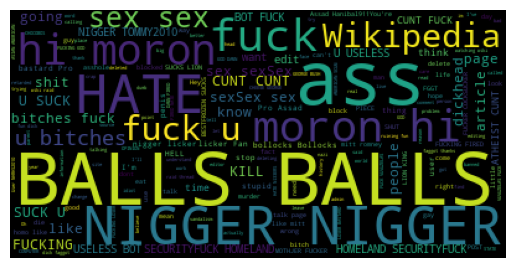

In [20]:
plt.imshow(cloud)
plt.axis('off');

Получилось интерсное облако слов)

Теперь построим облако слов для других комменариев

In [21]:
text = ' '.join(data[data['toxic'] == 0]['text'])

Учтем стоп-слова

In [22]:
cloud = WordCloud(stopwords=big_set_stop_words).generate(text)

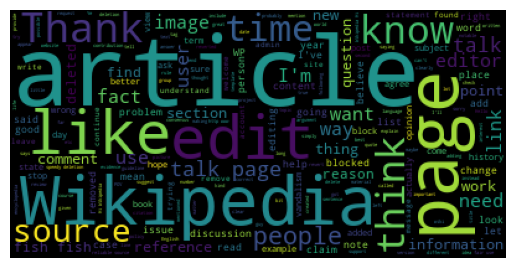

In [23]:
plt.imshow(cloud)
plt.axis('off');

# Предобработка данных

### Предобработка и лемматизация через SpaCy

In [24]:
nlp = spacy.load('en_core_web_sm')

def preprocessing_nlp_spacy(text): 
    doc = nlp(text, disable=["parser", "ner"])
    tokens = [token.text.lower() for token in doc]
    token_stop = [word for word in tokens if word not in big_set_stop_words]
    clean_re = ' '.join(re.sub(r'[^A-Za-z]', ' ', ' '.join(token_stop)).split())
    clean_single_character = ' '.join(re.sub(r'\s+[A-Za-z]\s+', ' ', clean_re).split())  
    doc = nlp(clean_single_character, disable=["tok2vec", "attribute_ruler", "parser", "ner"])
    lemma = ' '.join([lem.lemma_ for lem in doc])
    return lemma
    
    
    

In [25]:
data['lemm_text_spacy'] = data['text'].progress_apply(preprocessing_nlp_spacy)


  0%|          | 0/20000 [00:00<?, ?it/s]

C:\ProgramData\anaconda3\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


## Новая предобработка, включая POS-тегирование

1. lower_case
2. Токенизация
3. POS-тегирование
4. Удаление стоп-слов
5. Лемматизция с учетом POS-тегирования
6. Удаление одиночных букв, цифр, пунктуации с помощью re

In [26]:
tag_dict = {"J": wordnet.ADJ,
            "N": wordnet.NOUN,
            "V": wordnet.VERB,
            "R": wordnet.ADV}

lemmatizator = WordNetLemmatizer()


def get_wordnet_pos(word):
#     '''POS-теггинг. Возвращает значение части речи'''
    POS = nltk.pos_tag([word])[0][1][0].upper()
    return tag_dict.get(POS, wordnet.NOUN)


def preprocessing_nltk_with_POS(text):
    
#     1. Приведение к lowercase
#     2. Токенизация
#     3. POS-теггинг
#     4. Чистка по стоп-словам
#     5. Лемматизация с учетом POS-теггинга
#     6. re очистка одиночных символов, цифр, и подобное
 
    text = ' '.join([lemmatizator.lemmatize(word, get_wordnet_pos(word))\
                     for word in tokenize.word_tokenize(text.lower())\
                     if word not in big_set_stop_words])

    clean_re = ' '.join(re.sub(r'[^A-Za-z]', ' ', text).split())
    clean_single_character = ' '.join(re.sub(r'\s+[A-Za-z]\s+', ' ', clean_re).split())
    return clean_single_character

    
    

In [27]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alex\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [28]:
tqdm.pandas()
data['preprocessing_text_nltk_with_POS'] = data['text'].progress_apply(preprocessing_nltk_with_POS)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [29]:
data['preprocessing_text_nltk_with_POS'].head().values

array(['explanation edits username hardcore metallica fan revert vandalism closure gas vote new york doll fac remove template talk page retire now',
       'd aww match background colour seemingly stuck thanks talk january utc',
       'hey man try edit war guy constantly remove relevant information talk edits instead talk page care format actual info',
       'real suggestion improvement wonder section statistic later subsection type accident think reference need tidy exact format ie date format etc later no one preference format style reference want let know appear backlog article review guess delay reviewer turn list relevant form eg wikipedia good article nominations transport',
       'sir hero chance remember page'], dtype=object)

# WordCloud после предобработки

In [30]:
text = ' '.join(data[data['toxic'] == 1]['preprocessing_text_nltk_with_POS'])

Учтем стоп-слова

In [31]:
cloud = WordCloud(stopwords=big_set_stop_words).generate(text)

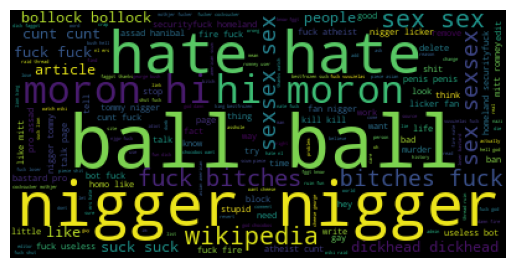

In [32]:
plt.imshow(cloud)
plt.axis('off');

Получилось интерсное облако слов)

Теперь построим облако слов для других комменариев

In [33]:
text = ' '.join(data[data['toxic'] == 0]['preprocessing_text_nltk_with_POS'])

Учтем стоп-слова

In [34]:
cloud = WordCloud(stopwords=big_set_stop_words).generate(text)

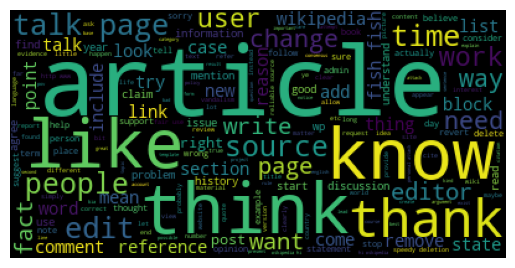

In [35]:
plt.imshow(cloud)
plt.axis('off');

### Проверка после предобработки

In [36]:
data.isna().mean()


text                                0.0
toxic                               0.0
neg                                 0.0
neu                                 0.0
pos                                 0.0
compound                            0.0
compound_binary                     0.0
count_stop_words                    0.0
count_word_upper                    0.0
lemm_text_spacy                     0.0
preprocessing_text_nltk_with_POS    0.0
dtype: float64

In [37]:
data = data.dropna()

# Дисбаланс классов

In [38]:
print(f'Общее число комментариев: {len(data) :.0f}')
print(f'Доля токсичных комментариев: {data["toxic"].mean() :.1%}')

Общее число комментариев: 20000
Доля токсичных комментариев: 10.3%


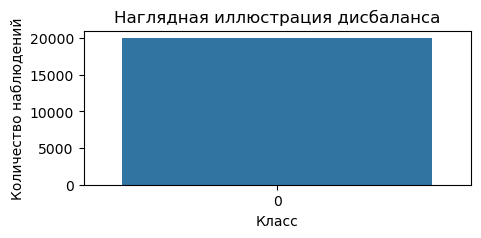

In [39]:
plt.figure(figsize=(5, 2))
sns.countplot(data['toxic'])
plt.xlabel('Класс')
plt.ylabel('Количество наблюдений')
plt.title('Наглядная иллюстрация дисбаланса');

Имеем сильный дисбаланс 1 к 8. 
    
Во-первых, для соотношения баланса буду использовать stratify.
Во-вторых, где возможно буду использовать weight_balanced.

И самое важное, что поможет бороться с дисбалансом - подбор порога. Сначала поставлю задачу каждой модели максимизировать метрику, не зависящую от порога, например ROC-AUC. На обученных моделях буду применять predict_proba и получать  score. Получив наибольший ROC-AUC на основании их, перебирая thrasholds буду получать различные значения F1-score. Максимизировав метрику применю score для train и test и уже адекватно оценю f1-score на выборках. **Это самый важный этап борьбы с дисбалансом классов.**

## Embeddings c Toxic-BERT на BERT

Прежде чем перевести тексты в векторы, подготовим их. У BERT есть собственный токенизатор. Это инструмент, который разбивает и преобразует исходные тексты в список токенов

Этот алгоритм понимает контекст запросов, а не просто анализирует фразы. Для машинного обучения она ценна тем, что помогает строить векторные представления. 

Инициализируем класс модели, будем работать с BERT. Инициализируем токенизатор и **загружаем веса предобученной модели на токсичных комментариях.**

In [40]:
!pip3 install transformers

In [41]:
model_class, tokenizer_class, pretrained_weights = transformers.BertModel, transformers.BertTokenizer, 'unitary/toxic-bert'

In [42]:
tokenizer_toxic = tokenizer_class.from_pretrained(pretrained_weights)
model_toxic = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Создаю выборку для обработки на BERT**

In [43]:
data_BERT = data.sample(n=SIZE_DATA_FOR_BERT, random_state=RANDOM_STATE).reset_index(drop=True)

In [44]:
tqdm.pandas()
tokenize_text = data_BERT['preprocessing_text_nltk_with_POS'].progress_apply(
lambda x: tokenizer_toxic.encode(x, add_special_tokens=True, truncation=True,
                                max_length=512)
)

  0%|          | 0/600 [00:00<?, ?it/s]

Найдем максимальную длину и применим паддинг:

In [45]:
max_len = tokenize_text.apply(lambda x: len(x)).max()
max_len

512

Применяем padding

In [46]:
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenize_text.values])

Создаем маску внимания

In [47]:
attention_mask = np.where(padded != 0, 1, 0)

In [48]:
attention_mask.shape

(600, 512)

Почти всё готово, чтобы сформировать векторы моделью toxic и классифицировать тексты. **В дело вступают тензоры.**

In [49]:
batch_size = 50
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
    
    with torch.no_grad():
        batch_embeddings = model_toxic(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:,0,:].numpy())


  0%|          | 0/12 [00:00<?, ?it/s]

In [50]:
feature_BERT_toxic = np.concatenate(embeddings)

Сохраню массив, чтобы в дальнейшем его просто подгружать, а не вычислять заново

In [51]:
# np.save('arr_BERT_TOXIC_EMBEDD', np.concatenate(embeddings))

In [52]:
feature_BERT_toxic.shape

(600, 768)

**Добавлю в data_BERT новую фичу Embeddings:**

In [53]:
data_BERT = data_BERT.merge(pd.DataFrame(feature_BERT_toxic), left_index=True, right_index=True)
data_BERT

,text,toxic,neg,neu,pos,compound,compound_binary,count_stop_words,count_word_upper,lemm_text_spacy,...,758,759,760,761,762,763,764,765,766,767
0,True. I can blame that on you and your arrogan...,0,0.279,0.640,0.081,-0.7769,0,15,4,true blame arrogance wp npa states comment con...,...,-0.602234,-0.582573,0.483467,-0.794872,-0.320485,0.514767,-0.246148,-0.676981,0.599093,0.555295
1,"""\n\n Teahouse talkback: You've got messages! ...",0,0.000,1.000,0.000,0.0000,1,0,1,teahouse talkback got messages,...,-0.583869,-1.158825,0.344810,-0.687849,0.044832,0.672782,-0.308994,-0.777315,0.558413,0.236773
2,"""\n\nI disagree that she edits without pushing...",0,0.081,0.857,0.062,-0.9373,0,339,39,disagree edits pushing pov desn like content u...,...,-0.729098,-1.062220,0.427103,-0.561648,-0.129941,0.637569,-0.516757,-0.894729,0.789429,0.419406
3,"Tim, there is no consistency on this point, al...",0,0.044,0.842,0.114,0.5423,1,24,5,tim consistency point course think able useful...,...,-0.525676,-1.145571,0.273743,-0.700262,0.132372,0.867694,-0.505854,-0.785364,0.514328,0.195821
4,""" I added a picture of him that is """"question...",0,0.000,0.935,0.065,0.3182,1,21,6,added picture question mr mrs smith know celeb...,...,-0.624664,-1.254780,0.251142,-0.715915,0.166665,0.728175,-0.488187,-0.790949,0.610525,0.156803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,". Finally, an entity is not notable enough for...",0,0.099,0.901,0.000,-0.3182,0,13,4,finally entity notable wikipedia wikipedia pag...,...,-0.568062,-1.158488,0.246155,-0.798800,0.190187,0.798594,-0.489234,-0.797328,0.350542,0.172698
596,What are you talking about? What edit wars? I'...,0,0.216,0.784,0.000,-0.6298,0,6,2,talking edit wars allowed edit profile,...,-0.563547,-1.164310,0.306832,-0.649588,0.015082,0.833410,-0.405427,-0.854110,0.436642,0.194179
597,"""\n\n""""What was cleverly inserted instead""""\nT...",0,0.092,0.788,0.120,0.2982,1,60,16,cleverly inserted instead thanks assuming bad ...,...,-0.811590,-0.869219,0.470883,-0.585237,-0.134708,0.624362,-0.465059,-0.802952,0.752392,0.542779
598,The Entire Canonical New Testament paragraph i...,0,0.142,0.806,0.052,-0.6328,0,23,17,entire canonical new testament paragraph wrong...,...,-0.748861,0.247240,0.136623,-1.108210,-0.016349,0.262482,0.190001,-0.542213,-0.193816,1.037586


# Разбиваю данные на train и test

**Сейчас у меня есть 2 датафрейма:**
* data 50к наблюдений
* data_BERT 2к наблюдений



**Разобьем на разные train и test! Поскольку где-то буду приметь TF-IDF на большом датасете, а где Embeddings!**

**Обязательно перемешиваем данные и применяем stratify для сохранения балансировки на выборках!**

Обычный data

In [54]:
train, test = train_test_split(data, test_size=0.2,
                                                    shuffle=True,
                                                    stratify=data['toxic'],
                                                    random_state=RANDOM_STATE)

**Это разбиение на data_BERT:**

In [55]:
train_BERT, test_BERT = train_test_split(data_BERT, test_size=0.2,
                                                    shuffle=True,
                                                    stratify=data_BERT['toxic'],
                                                    random_state=RANDOM_STATE)

# Обучение

Ранее мы расширили признаковое пространство, применив Feature Engeneering, векторизацию (TF-IDF) и Embeddings на DistillBert. Рассмотрим какие модели будем использовать дальше.

0. Baseline (CatBoost на изначальном тексте)
1. CatBoost на очищенном и преобразованном тексте
2. CatBoost на очищенном и преобразованном тексте + (RF-IDF)
3. CatBoost на очищенном и преобразованном тексте + (Embeddings)
4. Логистическая регрессия (TF-IDF)
5. Логистическая регрессия (Embeddings)


**Важное замечание по поводу дисбаланса классов. На моделях в качестве метрик изначально буду использовать ROC-AUC, поскольку данная метрика не зависит от порога. Получив максимальый ROC-AUC - обучу модель и буду подбирать порог, чтобы максимизировать уже метрику f1-score.**

**В идеале взять все уникальные пороги score из predict_proba**. Но поскольку ресурсы ограничены - возьму разбиение от 0 до 1 через np.linspace

## Pipeline 

**Для избежания утечки данных** буду использовать sklearn Pipeline.

После feature_engeneering у меня появились новые фичи. Их также нужно будет обработать в Pipeline - нормализовать.

Также поэксперементирую с фичами и посмотрю какие по мнению модели дают наибольший прирост. В этом мне поможет, например **CatBoost с его Feature Emportance.**

## Baseline (CatBoost на изначальном тексте)

В качестве baseline обучу CatBoost на изначальном тексте. Также повыбираю на нем важные фичи для обучения.

Зададим фичи:

In [56]:
feature = ['text', 'neg', 'neu', 'pos', 'compound', 'compound_binary',
       'count_stop_words', 'count_word_upper']
target = ['toxic']
text_features = ['text']

In [57]:
train_data = Pool(data=train[feature],
                 label=train[target],
                 text_features=text_features)

Для начала, на кросс-валидации подберу итерацию, **близкую** к 1000 (рекомендация catboost). Метрикой будет служить AUC, необходимо ее максимизировать.

In [58]:
params = {
    'auto_class_weights' : 'Balanced',
    'eval_metric' : 'AUC',
    'verbose' : 100,
    'random_seed' : RANDOM_STATE,
    'loss_function' : 'Logloss'
}

In [59]:
cv_data = cv(params=params,
            pool=train_data,
            fold_count=5,
            shuffle=True,
            partition_random_seed=RANDOM_STATE,
            stratified=True,
            verbose=False)

Training on fold [0/5]

bestTest = 0.9325163864
bestIteration = 435

Training on fold [1/5]

bestTest = 0.9446734851
bestIteration = 705

Training on fold [2/5]

bestTest = 0.9347629606
bestIteration = 486

Training on fold [3/5]

bestTest = 0.9425780795
bestIteration = 999

Training on fold [4/5]

bestTest = 0.9330687438
bestIteration = 662



Найдем лучшую итерацию для обучения (max AUC)

In [60]:
best_iter = cv_data[cv_data['test-AUC-mean'] == cv_data['test-AUC-mean'].max()]['iterations'].values[0] + 1
best_iter

649

Теперь изменим параметры обучения:

In [61]:
params = {
    'auto_class_weights' : 'Balanced',
    'eval_metric' : 'AUC',
    'verbose' : 100,
    'random_seed' : RANDOM_STATE,
    'loss_function' : 'Logloss',
    'iterations' : best_iter,
    'early_stopping_rounds' : 40
    
}

In [62]:
model = CatBoostClassifier(**params)

In [63]:
model.fit(train_data, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.050034
0:	total: 52.8ms	remaining: 34.2s
100:	total: 6.59s	remaining: 35.7s
200:	total: 13.2s	remaining: 29.4s
300:	total: 19.8s	remaining: 22.8s
400:	total: 26.2s	remaining: 16.2s
500:	total: 32.9s	remaining: 9.72s
600:	total: 39.3s	remaining: 3.14s
648:	total: 42.5s	remaining: 0us


Лучшее качество AUC на train

In [64]:
f1_score(model.predict(train_data), train['toxic'])

0.8010885700148441

**Попробуем улучшить метрику f1, подобрав нужный порог!**

In [65]:
train['y_score'] = model.predict_proba(train_data)[:, 1]

In [66]:
y_scores_thrasholds = np.linspace(0, 1, num=101)
f1_scores = []

for thrashholds in y_scores_thrasholds:
    y_pred = (train['y_score'] >= thrashholds).astype(int)
    f1 = f1_score(train['toxic'], y_pred)
    f1_scores.append(f1)
    
results_df = pd.DataFrame({'thrashholds' : y_scores_thrasholds, 
                          'f1' : f1_scores})
    


Максимальная метрика f1 на train при пороге:

In [67]:
max_f1_row = results_df.loc[results_df['f1'].idxmax()]
max_f1_row

thrashholds    0.780000
f1             0.872575
Name: 78, dtype: float64

In [68]:
best_thrash = max_f1_row['thrashholds']
best_thrash

0.78

**Интересно проверить как порог покажет себя на неизвестной ему выборке:**

In [69]:
f1_score((model.predict_proba(test[feature])[:, 1] > best_thrash)*1, test['toxic'])

0.7352185089974292

Посмотрим какие фичи како вклад внесли в предсказание

In [70]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,text,75.632073
1,neg,7.350840
2,count_stop_words,4.532930
3,compound,4.345528
4,neu,2.751798
5,pos,2.157890
6,count_word_upper,2.126232
7,compound_binary,1.102710


### Попробую обучить просто на тексте без доп.фич

In [71]:
feature = ['text']
target = ['toxic']
text_features = ['text']

In [72]:
train_data = Pool(data=train[feature],
                 label=train[target],
                 text_features=text_features)

Для начала, на кросс-валидации подберу итерацию, **близкую** к 1000 (рекомендация catboost). Метрикой будет служить AUC, необходимо ее максимизировать.

In [73]:
params = {
    'auto_class_weights' : 'Balanced',
    'eval_metric' : 'AUC',
    'verbose' : 100,
    'random_seed' : RANDOM_STATE,
    'loss_function' : 'Logloss'
}

In [74]:
cv_data = cv(params=params,
            pool=train_data,
            fold_count=5,
            shuffle=True,
            partition_random_seed=RANDOM_STATE,
            stratified=True,
            verbose=False)

Training on fold [0/5]

bestTest = 0.9106255871
bestIteration = 804

Training on fold [1/5]

bestTest = 0.9268653093
bestIteration = 436

Training on fold [2/5]

bestTest = 0.9153542393
bestIteration = 738

Training on fold [3/5]

bestTest = 0.9262870275
bestIteration = 470

Training on fold [4/5]

bestTest = 0.9264363555
bestIteration = 482



Найдем лучшую итерацию для обучения (max AUC)

In [75]:
best_iter = cv_data[cv_data['test-AUC-mean'] == cv_data['test-AUC-mean'].max()]['iterations'].values[0] + 1
best_iter

475

Теперь изменим параметры обучения:

In [76]:
params = {
    'auto_class_weights' : 'Balanced',
    'eval_metric' : 'AUC',
    'verbose' : 100,
    'random_seed' : RANDOM_STATE,
    'loss_function' : 'Logloss',
    'iterations' : best_iter,
    'early_stopping_rounds' : 40
    
}

In [77]:
model = CatBoostClassifier(**params)

In [78]:
model.fit(train_data, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.066614
0:	total: 52.1ms	remaining: 24.7s
100:	total: 6.48s	remaining: 24s
200:	total: 13.2s	remaining: 18s
300:	total: 19.9s	remaining: 11.5s
400:	total: 26.5s	remaining: 4.89s
474:	total: 31.7s	remaining: 0us


Лучшее качество f1 на train

In [79]:
f1_score(model.predict(train_data), train['toxic'])

0.7897334649555776

**Попробуем улучшить метрику f1, подобрав нужный порог!**

In [80]:
train['y_score'] = model.predict_proba(train_data)[:, 1]

In [81]:
y_scores_thrasholds = np.linspace(0, 1, num=101)
f1_scores = []

for thrashholds in y_scores_thrasholds:
    y_pred = (train['y_score'] >= thrashholds).astype(int)
    f1 = f1_score(train['toxic'], y_pred)
    f1_scores.append(f1)
    
results_df = pd.DataFrame({'thrashholds' : y_scores_thrasholds, 
                          'f1' : f1_scores})
    


Максимальная метрика f1 на train при пороге:

In [82]:
max_f1_row = results_df.loc[results_df['f1'].idxmax()]
max_f1_row

thrashholds    0.730000
f1             0.852571
Name: 73, dtype: float64

In [83]:
best_thrash = max_f1_row['thrashholds']
best_thrash

0.73

**Интересно проверить как порог покажет себя на неизвестной ему выборке:**

In [84]:
f1_score((model.predict_proba(test[feature])[:, 1] > best_thrash)*1, test['toxic'])

0.7018867924528303

<div class="alert alert-info">
    <br /> 
    <font size="3", color = "black">
<br />  
       **Могу сделать вывод, что feature_engenerring немного улучшает метрику!!**


**Таким образом, на чистом catboost и необработанном тексте с подбором порога. Получили метрику на baseline 0.7. Feature Engeneering немного улучшил качество!**

## CatBoost на очищенном и преобразованном тексте (+ его внутренняя обработка текста)

Зададим фичи:

In [85]:
feature = ['preprocessing_text_nltk_with_POS', 'neg', 'neu', 'pos', 'compound', 'compound_binary',
       'count_stop_words', 'count_word_upper']
target = ['toxic']
text_features = ['preprocessing_text_nltk_with_POS']

In [86]:
train_data = Pool(data=train[feature],
                 label=train[target],
                 text_features=text_features)

Для начала, на кросс-валидации подберу итерацию, **близкую** к 1000 (рекомендация catboost). Метрикой будет служить AUC, необходимо ее максимизировать.

In [87]:
params = {
    'auto_class_weights' : 'Balanced',
    'eval_metric' : 'AUC',
    'verbose' : 100,
    'random_seed' : RANDOM_STATE,
    'loss_function' : 'Logloss'
}

In [88]:
cv_data = cv(params=params,
            pool=train_data,
            fold_count=5,
            shuffle=True,
            partition_random_seed=RANDOM_STATE,
            stratified=True,
            verbose=False)

Training on fold [0/5]

bestTest = 0.9461828314
bestIteration = 655

Training on fold [1/5]

bestTest = 0.9476351815
bestIteration = 804

Training on fold [2/5]

bestTest = 0.9480788723
bestIteration = 865

Training on fold [3/5]

bestTest = 0.9515255817
bestIteration = 999

Training on fold [4/5]

bestTest = 0.94491967
bestIteration = 991



Найдем лучшую итерацию для обучения (max AUC)

In [89]:
best_iter = cv_data[cv_data['test-AUC-mean'] == cv_data['test-AUC-mean'].max()]['iterations'].values[0] + 1
best_iter

992

Теперь изменим параметры обучения:

In [90]:
params = {
    'auto_class_weights' : 'Balanced',
    'eval_metric' : 'AUC',
    'verbose' : 100,
    'random_seed' : RANDOM_STATE,
    'loss_function' : 'Logloss',
    'iterations' : best_iter,
    'early_stopping_rounds' : 40
    
}

In [91]:
model = CatBoostClassifier(**params)

In [92]:
model.fit(train_data, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.033907
0:	total: 51.6ms	remaining: 51.2s
100:	total: 6.54s	remaining: 57.7s
200:	total: 13.2s	remaining: 51.8s
300:	total: 19.7s	remaining: 45.2s
400:	total: 26.2s	remaining: 38.7s
500:	total: 32.9s	remaining: 32.3s
600:	total: 39.5s	remaining: 25.7s
700:	total: 46.1s	remaining: 19.1s
800:	total: 52.6s	remaining: 12.5s
900:	total: 59.2s	remaining: 5.98s
991:	total: 1m 5s	remaining: 0us


Лучшее качество f1 на train

In [93]:
f1_score(model.predict(train_data), train['toxic'])

0.8344577062791905

**Попробуем улучшить метрику f1, подобрав нужный порог!**

In [94]:
train['y_score'] = model.predict_proba(train_data)[:, 1]

In [95]:
y_scores_thrasholds = np.linspace(0, 1, num=101)
f1_scores = []

for thrashholds in y_scores_thrasholds:
    y_pred = (train['y_score'] >= thrashholds).astype(int)
    f1 = f1_score(train['toxic'], y_pred)
    f1_scores.append(f1)
    
results_df = pd.DataFrame({'thrashholds' : y_scores_thrasholds, 
                          'f1' : f1_scores})
    


Максимальная метрика f1 на train при пороге:

In [96]:
max_f1_row = results_df.loc[results_df['f1'].idxmax()]
max_f1_row

thrashholds    0.72000
f1             0.88473
Name: 72, dtype: float64

In [97]:
best_thrash = max_f1_row['thrashholds']
best_thrash

0.72

**Интересно проверить как порог покажет себя на неизвестной ему выборке:**

In [98]:
f1_score((model.predict_proba(test[feature])[:, 1] > best_thrash)*1, test['toxic'])

0.7719298245614035

Посмотрим какие фичи како вклад внесли в предсказание

In [99]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,preprocessing_text_nltk_with_POS,79.589734
1,neg,5.075033
2,count_stop_words,4.417467
3,compound,3.448470
4,neu,2.723334
5,count_word_upper,2.655924
6,pos,1.227732
7,compound_binary,0.862306


<div class="alert alert-info">
    <br /> 
    <font size="3", color = "black">
<br />  
       На данной модели удалось пробить метрику 0.75


## CatBoost на очищенном и преобразованном тексте + (TF-IDF) 

Здесь уже необходимо использовать pipeline, чтобы избежать утечки данных на tf-idf

In [100]:
train

,text,toxic,neg,neu,pos,compound,compound_binary,count_stop_words,count_word_upper,lemm_text_spacy,preprocessing_text_nltk_with_POS,y_score
14919,"These four people include WLU, Ohnoitsjamie, Y...",0,0.113,0.805,0.082,-0.7791,0,108,35,people include wlu ohnoitsjamie yankees quarte...,people include wlu ohnoitsjamie yankees quarte...,0.064799
10460,I would like to reiterate my earlier demand as...,0,0.236,0.656,0.109,-0.8822,0,34,7,like reiterate earlier demand genuinely disenc...,like reiterate earlier demand genuinely disenc...,0.141624
9329,Sorry for discovering your comment https://en....,0,0.063,0.680,0.257,0.6124,1,6,3,sorry discovering comment https en wikipedia o...,sorry discover comment http en wikipedia org w...,0.014296
2746,| class=Stub | player=yes | needs-infobox=yes,0,0.000,1.000,0.000,0.0000,1,0,0,class stub player yes needs infobox yes,class stub player yes needs infobox yes,0.032396
10206,"Cleanup tag\nHi there,\nDo you have any specif...",0,0.000,0.879,0.121,0.4404,1,7,5,cleanup tag hi specific suggestions salt earth...,cleanup tag hi specific suggestion salt earth ...,0.008187
...,...,...,...,...,...,...,...,...,...,...,...,...
6661,"I've looked in my Dutch sources, but found no ...",0,0.059,0.893,0.048,-0.2235,0,31,14,looked dutch sources found mention giro consid...,look dutch source found mention giro consider ...,0.016892
14676,no abusing bots and stop being an idiot\nthe p...,1,0.233,0.716,0.050,-0.8493,0,29,0,abusing bots stop idiot pedigree mislabeled de...,abuse bot stop idiot pedigree mislabeled defin...,0.987570
13694,"""\nEditors are responsible for information the...",0,0.000,0.805,0.195,0.8910,1,28,6,editors responsible information add article in...,editor responsible information add article inf...,0.007550
7398,"""\n\nPostscript: In seriousness, I am all for ...",0,0.078,0.879,0.042,-0.0754,0,28,7,postscript seriousness keeping open mind think...,postscript seriousness keep open mind think wi...,0.018427


In [101]:
params

{'auto_class_weights': 'Balanced',
 'eval_metric': 'AUC',
 'verbose': 100,
 'random_seed': 42,
 'loss_function': 'Logloss',
 'iterations': 992,
 'early_stopping_rounds': 40}

In [102]:
X = ['neg', 'neu', 'pos', 'compound',
    'count_stop_words', 'count_word_upper',
    'preprocessing_text_nltk_with_POS']
y = ['toxic']

In [103]:
params = {'auto_class_weights': 'Balanced',
 'eval_metric': 'AUC',
 'verbose': 100,
 'random_seed': RANDOM_STATE,
 'loss_function': 'Logloss',
 'early_stopping_rounds': 40}

In [104]:
numeric_feature = ['neg', 'neu', 'pos', 'compound',
                  'count_stop_words', 'count_word_upper']

text_features = ['preprocessing_text_nltk_with_POS']

In [105]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

text_transformer = Pipeline(steps=[
    ('text', TfidfVectorizer())])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_feature),
        ('text_feature', text_transformer, 'preprocessing_text_nltk_with_POS')], remainder = 'passthrough')


pipe = Pipeline(steps=[
    ('preprocessor_features', preprocessor),
    ('catboost', CatBoostClassifier(**params))
    
])

In [106]:
pipe

Pipeline(steps=[('preprocessor_features',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['neg', 'neu', 'pos',
                                                   'compound',
                                                   'count_stop_words',
                                                   'count_word_upper']),
                                                 ('text_feature',
                                                  Pipeline(steps=[('text',
                                                                   TfidfVectorizer())]),
                                                  'preprocessing_text_nltk_with_POS')])),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x00000214C43A8520>)])

In [107]:
pipe.fit(train[X], train[y])

Learning rate set to 0.033658
0:	total: 191ms	remaining: 3m 10s
100:	total: 18.7s	remaining: 2m 46s
200:	total: 37.1s	remaining: 2m 27s
300:	total: 55.5s	remaining: 2m 8s
400:	total: 1m 14s	remaining: 1m 50s
500:	total: 1m 32s	remaining: 1m 32s
600:	total: 1m 51s	remaining: 1m 13s
700:	total: 2m 9s	remaining: 55.2s
800:	total: 2m 27s	remaining: 36.7s
900:	total: 2m 46s	remaining: 18.2s
999:	total: 3m 4s	remaining: 0us


Pipeline(steps=[('preprocessor_features',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['neg', 'neu', 'pos',
                                                   'compound',
                                                   'count_stop_words',
                                                   'count_word_upper']),
                                                 ('text_feature',
                                                  Pipeline(steps=[('text',
                                                                   TfidfVectorizer())]),
                                                  'preprocessing_text_nltk_with_POS')])),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x00000214C43A8520>)])

In [108]:
f1_score(pipe.predict(train[X]), train['toxic'])

0.8145580589254765

**Попробуем улучшить метрику f1, подобрав нужный порог!**

In [109]:
train['y_score'] = pipe.predict_proba(train[X])[:, 1]

In [110]:
y_scores_thrasholds = np.linspace(0, 1, num=101)
f1_scores = []

for thrashholds in y_scores_thrasholds:
    y_pred = (train['y_score'] >= thrashholds).astype(int)
    f1 = f1_score(train['toxic'], y_pred)
    f1_scores.append(f1)
    
results_df = pd.DataFrame({'thrashholds' : y_scores_thrasholds, 
                          'f1' : f1_scores})
    


Максимальная метрика f1 на train при пороге:

In [111]:
max_f1_row = results_df.loc[results_df['f1'].idxmax()]
max_f1_row

thrashholds    0.540000
f1             0.842267
Name: 54, dtype: float64

In [112]:
best_thrash = max_f1_row['thrashholds']
best_thrash

0.54

**Интересно проверить как порог покажет себя на неизвестной ему выборке:**

In [113]:
f1_score((model.predict_proba(test[feature])[:, 1] > best_thrash)*1, test['toxic'])

0.7272727272727272

<div class="alert alert-info">
    <br /> 
    <font size="3", color = "black">
<br />  
       На данном модели удалось пробить метрику 0.75

## Логистическая регрессия (TF-IDF)

In [114]:
X = ['neg', 'neu', 'pos', 'compound',
    'count_stop_words', 'count_word_upper',
    'preprocessing_text_nltk_with_POS']
y = ['toxic']

In [115]:
numeric_feature = ['neg', 'neu', 'pos', 'compound',
                  'count_stop_words', 'count_word_upper']

text_features = ['preprocessing_text_nltk_with_POS']

In [116]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

text_transformer = Pipeline(steps=[
    ('text', TfidfVectorizer())])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_feature),
        ('text_feature', text_transformer, 'preprocessing_text_nltk_with_POS')], remainder = 'passthrough')


pipe = Pipeline(steps=[
    ('preprocessor_features', preprocessor),
    ('logreg', LogisticRegression(random_state=RANDOM_STATE))
    
])

In [117]:
pipe

Pipeline(steps=[('preprocessor_features',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['neg', 'neu', 'pos',
                                                   'compound',
                                                   'count_stop_words',
                                                   'count_word_upper']),
                                                 ('text_feature',
                                                  Pipeline(steps=[('text',
                                                                   TfidfVectorizer())]),
                                                  'preprocessing_text_nltk_with_POS')])),
                ('logreg', LogisticRegression(random_state=42))])

In [118]:
pipe.fit(train[X], train[y])

C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor_features',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['neg', 'neu', 'pos',
                                                   'compound',
                                                   'count_stop_words',
                                                   'count_word_upper']),
                                                 ('text_feature',
                                                  Pipeline(steps=[('text',
                                                                   TfidfVectorizer())]),
                                                  'preprocessing_text_nltk_with_POS')])),
                ('logreg', LogisticRegression(random_state=42))])

In [119]:
f1_score(pipe.predict(train[X]), train['toxic'])

0.6961240310077519

**Попробуем улучшить метрику f1, подобрав нужный порог!**

In [120]:
train['y_score'] = pipe.predict_proba(train[X])[:, 1]

In [121]:
y_scores_thrasholds = np.linspace(0, 1, num=101)
f1_scores = []

for thrashholds in y_scores_thrasholds:
    y_pred = (train['y_score'] >= thrashholds).astype(int)
    f1 = f1_score(train['toxic'], y_pred)
    f1_scores.append(f1)
    
results_df = pd.DataFrame({'thrashholds' : y_scores_thrasholds, 
                          'f1' : f1_scores})
    


Максимальная метрика f1 на train при пороге:

In [122]:
max_f1_row = results_df.loc[results_df['f1'].idxmax()]
max_f1_row

thrashholds    0.270000
f1             0.794529
Name: 27, dtype: float64

In [123]:
best_thrash = max_f1_row['thrashholds']
best_thrash

0.27

**Интересно проверить как порог покажет себя на неизвестной ему выборке:**

In [124]:
test['toxic']

3558     0
18721    0
2362     0
13480    0
2249     0
        ..
6055     0
7622     0
16715    1
19233    1
13485    0
Name: toxic, Length: 4000, dtype: int64

In [125]:
f1_score((pipe.predict_proba(test[X])[:, 1] > best_thrash)*1, test['toxic'])

0.7300380228136882

## Логистическая регрессия (Embeddings)

In [126]:
X = list(train_BERT.drop(['toxic', 'preprocessing_text_nltk_with_POS', 'text', 'lemm_text_spacy', 'compound_binary'], axis=1).columns)
y = ['toxic']

In [127]:
X = [str(i) for i in X]

In [128]:
numeric_feature = ['neg', 'neu', 'pos', 'compound',
                  'count_stop_words', 'count_word_upper']



In [129]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])



preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_feature)], remainder='passthrough')


pipe = Pipeline(steps=[
    ('preprocessor_features', preprocessor),
    ('LogisticRegression', LogisticRegression(class_weight='balanced', max_iter=500, random_state=RANDOM_STATE))
    
])

In [130]:
pipe

Pipeline(steps=[('preprocessor_features',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['neg', 'neu', 'pos',
                                                   'compound',
                                                   'count_stop_words',
                                                   'count_word_upper'])])),
                ('LogisticRegression',
                 LogisticRegression(class_weight='balanced', max_iter=500,
                                    random_state=42))])

In [140]:
train_BERT.columns = train_BERT.columns.astype(str)
test_BERT.columns = test_BERT.columns.astype(str)

In [132]:
pipe.fit(train_BERT[X], train_BERT[y])

C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('preprocessor_features',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['neg', 'neu', 'pos',
                                                   'compound',
                                                   'count_stop_words',
                                                   'count_word_upper'])])),
                ('LogisticRegression',
                 LogisticRegression(class_weight='balanced', max_iter=500,
                                    random_state=42))])

In [141]:
f1_score(pipe.predict(train_BERT[X]), train_BERT['toxic'])

1.0

**Попробуем улучшить метрику f1, подобрав нужный порог!**

In [142]:
train_BERT['y_score'] = pipe.predict_proba(train_BERT[X])[:, 1]

In [146]:
y_scores_thrasholds = np.linspace(0, 1, num=101)
f1_scores = []

for thrashholds in y_scores_thrasholds:
    y_pred = (train_BERT['y_score'] >= thrashholds).astype(int)
    f1 = f1_score(train_BERT['toxic'], y_pred)
    f1_scores.append(f1)
    
results_df = pd.DataFrame({'thrashholds' : y_scores_thrasholds, 
                          'f1' : f1_scores})
    


Максимальная метрика f1 на train при пороге:

In [147]:
max_f1_row = results_df.loc[results_df['f1'].idxmax()]
max_f1_row

thrashholds    0.5
f1             1.0
Name: 50, dtype: float64

In [148]:
best_thrash = max_f1_row['thrashholds']
best_thrash

0.5

**Интересно проверить как порог покажет себя на неизвестной ему выборке:**

In [149]:
test_BERT['toxic']

579    0
290    0
112    0
535    0
515    1
      ..
314    0
356    0
456    0
403    0
58     0
Name: toxic, Length: 120, dtype: int64

In [150]:
f1_score((pipe.predict_proba(test_BERT[X])[:, 1] > best_thrash)*1, test_BERT['toxic'])

0.9090909090909091

# Выводы

В данном проекте мы построили классификаторы токсичных текстов, модель CatBoost с очищенными текстами хорошо себя проявила и пробила порог по f1 0.75, получив метрику 0.93 на train c помощью CatBoost. Метрика на test - 0.83  

На всех моделях использовался подбор порога, который помог повысить метрику в условиях сильно дисбаланса классов.